# 1. 股票价格预测

## 1.1 问题定义

1. Motivation是什么？投资组合管理
    
2. 问题是什么？
问题：进行未来的股票价格的预测   
监督学习：回归问题（线性回归模型、SVM模型、神经网络模型）    
输入：股票基本面数据（收盘价、成交量等）、财务数据（PE等）     
输出：未来一日或几日的股票价格，决定进行买入或卖出操作     
     
3. Pipline是什么？     
特征工程（数据清洗、特征选择、特征构建等） + 模型构建（训练）
    
4. 评价指标是什么？    
（1）均方根误差RMSE     
（2）统计检验R2=SSR/SST=1-SSE/SST     
其中：SST=SSR+SSE，SST(total sum of squares)为总平方和，SSR(regression sum of squares)为回归平方和，SSE(error sum of squares) 为残差平方和。     
For example:
lets say that we have 5, 6, 7, and 8, and a model predicts the outcomes as 4.5, 6.3, 7.2, and 7.9. Then,
SSE can be calculated as: SSE = (5 – 4.5) ^ 2 + (6 – 6.3) ^ 2 + (7 – 7.2) ^ 2 + (8 – 7.9) ^ 2;
and SST can be calculated as: mean = (5 + 6 + 7 + 8) / 4 = 6.5; SST = (5 – 6.5) ^ 2 + (6 – 6.5) ^ 2 + (7 – 6.5) ^ 2 + (8 – 6.5) ^ 2

## 1.2 sklearn.linear_model.LinearRegression¶

API =>  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html    
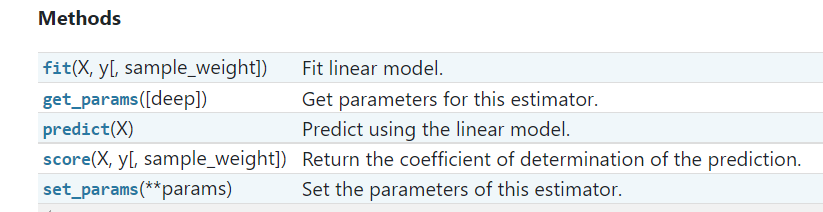

In [1]:
# 梯度下降
def gradient_descend(self, g_w, g_b, step=0.01):
    self.w = self.w - g_w * step
    self.b = self.b - g_b * step

# 训练
def fit(self,x,y):
    count = 1
    precsion = 0.0001
    w_last = self.w + 1
    b_last = self.b + 1
    size = x.shape[0]
    while True:
        # 终止迭代
        if (np.abs(w_last - self.w) < precsion) and (np.abs(b_last - self.b) < precsion):
            break
        if count > 3000:
            break
        g_w = 0 
        g_b = 0         
        for xi,yi in zip(x,y):
            g_w += self.loss(xi,yi)[0]/size
            g_b += self.loss(xi,yi)[1]/size
        # 记录上一次记录
        w_last = self.w
        b_last = self.b
        self.gradient_descend(g_w,g_b)
        count += 1

## 1.3 线性回归模型

### 导入工具库

In [2]:
import pandas as pd
import numpy as np
import math,datetime
import time
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split

### 加载数据

In [3]:
df = pd.read_csv('data/GOOG.csv',index_col='Date',parse_dates=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-29,1341.459961,1359.989990,1325.339966,1341.479980,1341.479980,3793600
2020-04-30,1324.880005,1352.819946,1322.489990,1348.660034,1348.660034,2668900
2020-05-01,1328.500000,1352.069946,1311.000000,1320.609985,1320.609985,2072500
2020-05-04,1308.229980,1327.660034,1299.000000,1326.800049,1326.800049,1504000
2020-05-05,1337.920044,1373.939941,1337.459961,1351.109985,1351.109985,1650700


数据日期范围：[2004-08-19，2020-05-05] 

### 对数据做简单分析

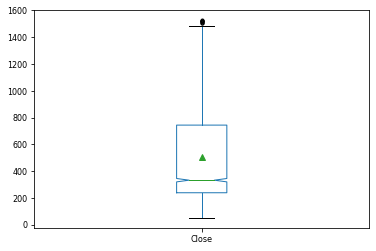

In [6]:
# 箱型图：1. 直观明了地识别数据批中的异常值；2. 利用箱线图判断数据批的偏态和尾重。
# sym:表示异常点形状
plt.figure(figsize=(6, 4))
df[['Close']].boxplot(showmeans=True, fontsize=8, notch = True, sym = '.', grid=False)

### 特征工程

构建新特征

In [7]:
# 单日价格变化率
df['OC_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100

In [8]:
# 单日最大价格差
df['HL_Change'] = (df['High'] - df['Low']) / df['Low'] * 100

In [9]:
# 模型使用的特征
df = df[['Close','HL_Change','OC_Change','Volume']]

In [10]:
df.head()

,Close,HL_Change,OC_Change,Volume
Date,,,,
2004-08-19,49.982655,8.441021,0.340008,44871300
2004-08-20,53.952770,8.537311,7.227003,22942800
2004-08-23,54.495735,4.062359,-1.218966,18342800
2004-08-24,52.239193,7.753212,-5.726359,15319700
2004-08-25,52.802086,3.966114,0.990855,9232100


In [11]:
df.index.tolist()[0:5]

[Timestamp('2004-08-19 00:00:00'),
 Timestamp('2004-08-20 00:00:00'),
 Timestamp('2004-08-23 00:00:00'),
 Timestamp('2004-08-24 00:00:00'),
 Timestamp('2004-08-25 00:00:00')]

In [12]:
df.index.tolist()[-5:]

[Timestamp('2020-04-29 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-05-04 00:00:00'),
 Timestamp('2020-05-05 00:00:00')]

In [13]:
df.tail()

,Close,HL_Change,OC_Change,Volume
Date,,,,
2020-04-29,1341.479980,2.614425,0.001492,3793600
2020-04-30,1348.660034,2.293398,1.794882,2668900
2020-05-01,1320.609985,3.132719,-0.593904,2072500
2020-05-04,1326.800049,2.206315,1.419480,1504000
2020-05-05,1351.109985,2.727557,0.985854,1650700


### 标签列Labels的确定

In [15]:
import copy
# 作为推理过程的输入数据
df_Mark =  copy.deepcopy(df)
df_Mark

,Close,HL_Change,OC_Change,Volume
Date,,,,
2004-08-19,49.982655,8.441021,0.340008,44871300
2004-08-20,53.952770,8.537311,7.227003,22942800
2004-08-23,54.495735,4.062359,-1.218966,18342800
2004-08-24,52.239193,7.753212,-5.726359,15319700
2004-08-25,52.802086,3.966114,0.990855,9232100
...,...,...,...,...
2020-04-29,1341.479980,2.614425,0.001492,3793600
2020-04-30,1348.660034,2.293398,1.794882,2668900
2020-05-01,1320.609985,3.132719,-0.593904,2072500


In [14]:
# forecast_out表示测试集大小
forecast_out = int(math.ceil(0.01*len(df)))
forecast_out

40

In [16]:
# 记录测试集（用于推理过程）收盘价
Close_Mark = df['Close'][-40:].to_numpy()
Close_Mark

array([1280.390015, 1215.410034, 1114.910034, 1219.72998 , 1084.329956,
       1119.800049, 1096.800049, 1115.290039, 1072.319946, 1056.619995,
       1134.459961, 1102.48999 , 1161.75    , 1110.709961, 1146.819946,
       1162.810059, 1105.619995, 1120.839966, 1097.880005, 1186.920044,
       1186.51001 , 1210.280029, 1211.449951, 1217.560059, 1269.22998 ,
       1262.469971, 1263.469971, 1283.25    , 1266.609985, 1216.339966,
       1263.209961, 1276.310059, 1279.310059, 1275.880005, 1233.670044,
       1341.47998 , 1348.660034, 1320.609985, 1326.800049, 1351.109985])

In [17]:
forecast_Col = 'Close'
df['Label'] = df['Close'].shift(- 1)
df['Label']  # (3955,)

Date
2004-08-19      53.952770
2004-08-20      54.495735
2004-08-23      52.239193
2004-08-24      52.802086
2004-08-25      53.753517
                 ...     
2020-04-29    1348.660034
2020-04-30    1320.609985
2020-05-01    1326.800049
2020-05-04    1351.109985
2020-05-05            NaN
Name: Label, Length: 3955, dtype: float64

### 数据集划分

In [18]:
X  =  np.array(df.drop(['Label'], axis = 1)[0:-forecast_out])
Y  =  np.array(df['Label'][0:-forecast_out])

In [19]:
print(len(X),len(Y))

3915 3915


In [20]:
X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(X,Y,test_size = 0.2)

In [21]:
a = np.shape(X_train)
b = np.shape(Y_train)
c = np.shape(X_valid)
d = np.shape(Y_valid)
print(a,b,c,d)

(3132, 4) (3132,) (783, 4) (783,)



### 应用线性回归模型

In [22]:
startlr = time.time()

lr = LinearRegression()
lr.fit(X_train,Y_train)

endlr = time.time()

time_lr = endlr-startlr

print('训练时间:{}'.format(time_lr))

训练时间:0.001996278762817383


In [23]:
accuracy = lr.score(X_valid,Y_valid)
print("线性模型的验证集准确率为： {}".format(accuracy))

线性模型的验证集准确率为： 0.9992284278269729


### 推理过程

In [24]:
df_Mark[-forecast_out:]

,Close,HL_Change,OC_Change,Volume
Date,,,,
2020-03-10,1280.390015,5.118275,1.618255,2611400
2020-03-11,1215.410034,5.425269,-2.743852,2608500
2020-03-12,1114.910034,7.237038,-0.984899,4226700
2020-03-13,1219.729980,9.185670,3.454621,3700100
2020-03-16,1084.329956,7.243497,-1.064785,4252400
2020-03-17,1119.800049,7.087999,2.441663,3861500
2020-03-18,1096.800049,6.673219,3.813503,4233400
2020-03-19,1115.290039,9.231318,2.034673,3651100
2020-03-20,1072.319946,7.367502,-5.582364,3601800


In [25]:
# 预测输出 
infer_X = np.array(df_Mark[-forecast_out:-1])
forecast_set = lr.predict(infer_X)
print(forecast_set)

[1280.41655434 1216.26780589 1115.49322823 1219.54506177 1084.93375279
 1119.74921133 1096.47896132 1115.39125109 1073.7789387  1057.0661055
 1134.25156074 1103.24163595 1161.3129283  1111.26921449 1146.81180393
 1162.84933237 1106.18300336 1120.75025851 1098.56186357 1186.48492135
 1187.33185022 1210.48929232 1211.89804675 1217.7075277  1269.15261751
 1262.502817   1263.88233519 1283.50032682 1266.90171331 1217.09457329
 1263.23238793 1276.48836757 1279.29917675 1276.41319405 1234.76012146
 1341.6883294  1348.54447673 1320.98149823 1326.77665244]


In [26]:
# 真实输出——收盘价
Close_Mark[1:]

array([1215.410034, 1114.910034, 1219.72998 , 1084.329956, 1119.800049,
       1096.800049, 1115.290039, 1072.319946, 1056.619995, 1134.459961,
       1102.48999 , 1161.75    , 1110.709961, 1146.819946, 1162.810059,
       1105.619995, 1120.839966, 1097.880005, 1186.920044, 1186.51001 ,
       1210.280029, 1211.449951, 1217.560059, 1269.22998 , 1262.469971,
       1263.469971, 1283.25    , 1266.609985, 1216.339966, 1263.209961,
       1276.310059, 1279.310059, 1275.880005, 1233.670044, 1341.47998 ,
       1348.660034, 1320.609985, 1326.800049, 1351.109985])

In [27]:
date= ['2020-03-10','2020-03-11','2020-03-12','2020-03-13','2020-03-16','2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-23',
       '2020-03-24','2020-03-25','2020-03-26','2020-03-27','2020-03-30','2020-03-31','2020-04-01','2020-04-02','2020-04-03','2020-04-06',
       '2020-04-07','2020-04-08','2020-04-09','2020-04-13','2020-04-14','2020-04-15','2020-04-16','2020-04-17','2020-04-20','2020-04-21',
       '2020-04-22','2020-04-23','2020-04-24','2020-04-27','2020-04-28','2020-04-29','2020-04-30','2020-05-01','2020-05-04']
cl = Close_Mark[1:]
pr = forecast_set
result = pd.DataFrame({'Date': date, 'TomorrowRealClose': cl, 'Prediction': pr}, columns=['Date', 'TomorrowRealClose', 'Prediction'])
result

,Date,TomorrowRealClose,Prediction
0,2020-03-10,1215.410034,1280.416554
1,2020-03-11,1114.910034,1216.267806
2,2020-03-12,1219.729980,1115.493228
3,2020-03-13,1084.329956,1219.545062
4,2020-03-16,1119.800049,1084.933753
5,2020-03-17,1096.800049,1119.749211
6,2020-03-18,1115.290039,1096.478961
7,2020-03-19,1072.319946,1115.391251
8,2020-03-20,1056.619995,1073.778939
9,2020-03-23,1134.459961,1057.066105


## 注意：这里5月4日的TomorrowRealClose其实是5月5日的收盘价
## 5月4日的Prediction是依据4日的输入4维度特征进行预测的5日收盘价
## 所以，这就是错位思想。

In [28]:
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(cl, pr))
RMSE

50.04636506825478

### 结果可视化

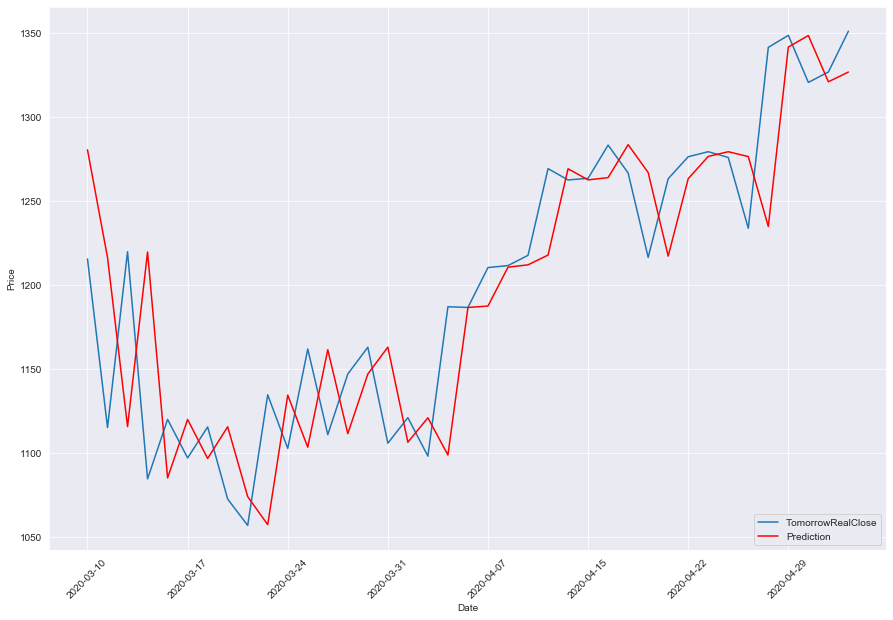

In [29]:
import seaborn as sns
sns.set_style("darkgrid")

result['TomorrowRealClose'].plot(figsize = (15,10))
result['Prediction'].plot(figsize = (15,10), c='red')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(range(0,result.shape[0],5), result['Date'][::5], rotation=45)
plt.show()

In [31]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result['TomorrowRealClose'],
                    mode='lines',
                    name='Tomorrow Real Price')))
fig.add_trace(go.Scatter(x=result.index, y=result['Prediction'],
                    mode='lines',
                    name='Test Prediction Price'))
fig.update_layout(
    xaxis=dict(
        title_text='Date',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        tickmode='array',
        tickvals = [i for i in range(39)],
        ticktext = date
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LinearModel)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

# 1.4 思考：
对于这种滞后性应该如何缓解？
1. 数据角度：特征工程
2. 模型角度：时间序列模型

In [ ]:
数据处理
lookback